# Analysis

In [6]:
%load_ext autoreload
%autoreload 2
from utils import dpo_dependencies
from utils import base_dependencies
import random
import pandas as pd
import numpy as np
import shutil
import pandas as pd
from itertools import combinations
import json
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def dpo_pair_accuracies(fn, model, group_label, run_label):
    
    if run_label == 'datagroupX':
        group_label = 'xa'
    with open(fn, "r") as f:
        data = json.load(f)
    global_step = data["global_step"]
    train_batch_size = data["train_batch_size"]

    if 'disco' in model:
        model = 'DPO DiscoLeo Llama'
    elif 'llama' in model:
        model = 'DPO Llama'
    elif 'mistral' in model:
        model = 'DPO LeoLM Mistral'
    records = []
    for entry in data["log_history"]:
        if "eval_rewards/accuracies" in entry:
            epoch = entry["epoch"]
            eval_rewards_accuracies = entry["eval_rewards/accuracies"]
            eval_rewards_margins = entry["eval_rewards/margins"]
            adjusted_step = global_step * train_batch_size * epoch
            records.append({"model": model, "train_steps": adjusted_step, "win_rate": eval_rewards_accuracies, "margin": eval_rewards_margins, "userGroup": group_label, "run": run_label})
    df = pd.DataFrame(records)
    return df

models = ['sft_disco_llama8b_checkpoint2800', 'sft_llama8b_checkpoint2400', 'sft_leolm_mistral7b_checkpoint1600']
userGroups = ['ea', 'ta', 'xa']
dpo_variants = ['dataall', 'dataequality', 'datamodel', 'datainterAA', 'dataintraAA', 'datagroupX']

dfs = []
for dpo_variant in dpo_variants:
    for userGroup in userGroups:
        for model in models:
            fp = f"outputs/dpo_dev_eval/trainer_state_{model}_{dpo_variant}_{userGroup}.json"
            if os.path.exists(fp):
                #print(dpo_variant, userGroup, model)
                dfs.append(dpo_pair_accuracies(fp, model, userGroup, dpo_variant))

dev_stats = pd.concat(dfs)
dev_stats['model'] = dev_stats['model'].str.replace('sft_', 'dpo_')
dev_stats = dev_stats[dev_stats['train_steps'] > 8]

In [8]:
#plt.style.use('ggplot')

col_name_map = {
    'dataall': r'$(x,y_w,y_l)_\text{All}$',
    'dataequality': r'$(x,y_w,y_l)_{\text{All=}}$',
    'datamodel': r'$(x,y_w,y_l)_{\text{LLM=}}$',
    'datainterAA': r'$(x,y_w,y_l)_{\text{max. Inter-AA}}$',
    'dataintraAA': r'$(x,y_w,y_l)_{\text{max. Intra-AA}}$',
    'datagroupX': r'$(x,y_w,y_l)_{{(\text{All}_{ex}}{\longmapsto}{\text{max. Intra-AA}_{tg})}}$'
}

def dpo_plot_results(eval_stats, yvar):

    max_points = []

    if yvar == 'win_rate':
        label = "Win Rate"
        horiz_line = 0.5
    elif yvar == 'margin':
        label = "Avg. Reward Margin"
        horiz_line = 0
    g = sns.FacetGrid(eval_stats, col='run', col_wrap=3, height=2, aspect=1, sharey=True, sharex=False)
    g.map_dataframe(sns.lineplot, x='train_steps', y=yvar, hue='model', style='userGroup', markers=False, dashes={'ta': '', 'ea': (4, 2), 'xa': (6, 1, 1, 1)}, palette=[base_dependencies.return_model_color('disco'), base_dependencies.return_model_color('llama'), base_dependencies.return_model_color('leolm')])
    g.map(plt.axhline, y=horiz_line, color="red", linestyle=":")
    g.set_axis_labels("Train Instances", label)
    g.add_legend()
    g.set(xlim=(0, 2500))
    
    legend = g.legend
    custom_labels = ['Model', base_dependencies.return_proper_model_name('disco'), base_dependencies.return_proper_model_name('llama'), base_dependencies.return_proper_model_name('leolm'), '\nAnnotator Group', 'Expert', 'Target', r'$\text{Expert}_{\text{train}}$, $\text{Target}_{\text{test}}$']
    for t, label in zip(legend.texts, custom_labels):
        t.set_text(label)

    # Find the maximum win_rate for each model-userGroup combo and add a circle
    for i, (ax, title) in enumerate(zip(g.axes.flat, g.col_names)):
        ax.xaxis.set_tick_params(labelbottom=True)
        for model in eval_stats['model'].unique():
            for userGroup in eval_stats['userGroup'].unique():
                # Filter the data for the current subplot (run)
                subset = eval_stats[(eval_stats['model'] == model) & (eval_stats['userGroup'] == userGroup) & (eval_stats['run'] == title)]
                    
                if not subset.empty:
                    max_point = subset.loc[subset[yvar].idxmax()]  # Get the point with max win_rate
                    if yvar == 'win_rate':
                        max_points.append(pd.DataFrame([max_point]))
                        if i == 0:
                            ax.plot(max_point['train_steps'], max_point[yvar], 'o', markersize=6, 
                                markeredgecolor='black', markerfacecolor='none')  # Black circle

        ax.set_title(col_name_map.get(title, title))
        ax.grid(True, axis='y')
        if yvar == 'win_rate':
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

    for ax, title in zip(g.axes.flat, g.col_names):
        ax.set_title(col_name_map.get(title, title))
        ax.grid(True, axis='y')
        if yvar == 'win_rate':
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
            ax.set_ylim([0.4, 0.75])
            ax.set_yticks([0.4, 0.5, 0.6, 0.7])
        elif yvar == 'margin':
            ax.set_ylim([-0.2, 0.6])
            ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])
    g.legend.set_bbox_to_anchor((1.33, 0.45))
        
    # Find the maximum win_rate for each model-userGroup combo and add a circle
    for i, (ax, title) in enumerate(zip(g.axes.flat, g.col_names)):
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

    #plt.tight_layout()
    #plt.suptitle(f"{label} on Eval Set During DPO Trainings", fontsize=16)
    #plt.subplots_adjust(top=1)
    plt.tight_layout()
    plt.subplots_adjust(wspace=.15, hspace=0.8)

    for ax in g.axes.flat:
        ax.set_xlabel("Training Instances")
        
    if yvar == 'win_rate':
        file_name = 'figures/win-rate-data.png'
    else:
        file_name = 'figures/margin-data.png'
    plt.savefig(file_name, dpi=800, bbox_inches='tight')
    plt.show()

    if yvar == 'win_rate':
        max_points = pd.concat(max_points)
        max_points['model'] = max_points['model'].map({'DPO DiscoLeo Llama': 'sft_disco_llama8b_checkpoint2800', 'DPO Llama': 'sft_llama8b_checkpoint2400', 'DPO LeoLM Mistral': 'sft_leolm_mistral7b_checkpoint1600'})
        max_points['run'] = max_points['run'].map({'dataall': 'all', 'dataequality': 'equality', 'datamodel': 'model', 'datainterAA': 'interAA', 'dataintraAA': 'intraAA', 'datagroupX': 'groupX'})
        max_points['train_steps'] = (max_points['train_steps']/8).astype(int)
        return max_points #[['model', 'train_steps', 'userGroup', 'run']]

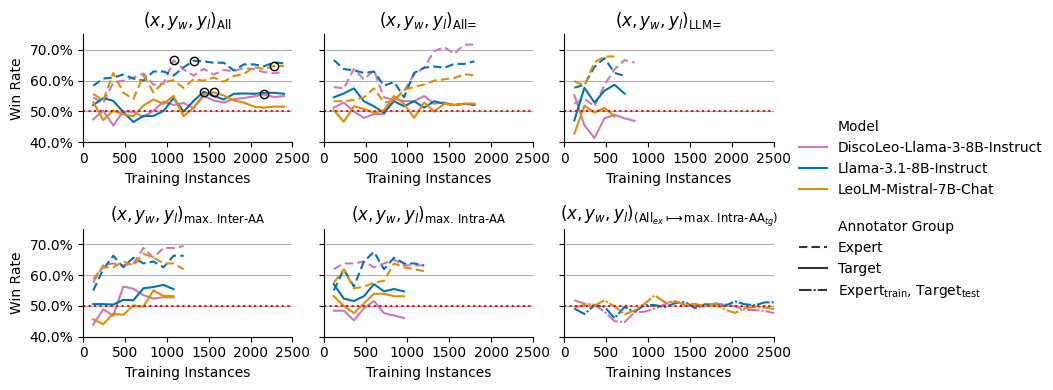

In [9]:
max_points_devwr = dpo_plot_results(dev_stats, 'win_rate')

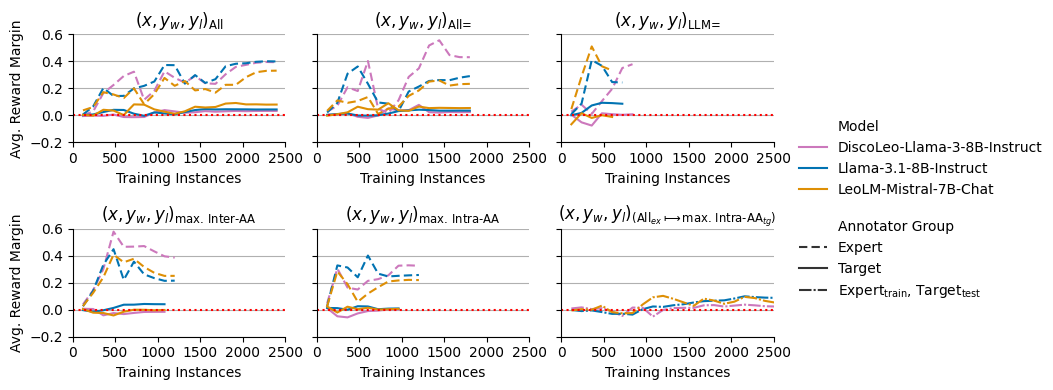

In [10]:
max_points_devmar = dpo_plot_results(dev_stats, 'margin')

In [157]:
dfs = []
for dpo_variant in dpo_variants:
    for userGroup in userGroups:
        for model in models:
            fp = f"outputs/dpo_test_eval/trainer_state_{model}_{dpo_variant}_{userGroup}.json"
            if os.path.exists(fp):
                #print(dpo_variant, userGroup, model)
                dfs.append(dpo_pair_accuracies(fp, model, userGroup, dpo_variant))

test_stats = pd.concat(dfs)
test_stats['model'] = test_stats['model'].str.replace('sft_', 'dpo_')
test_stats = test_stats[test_stats['train_steps'] > 8]

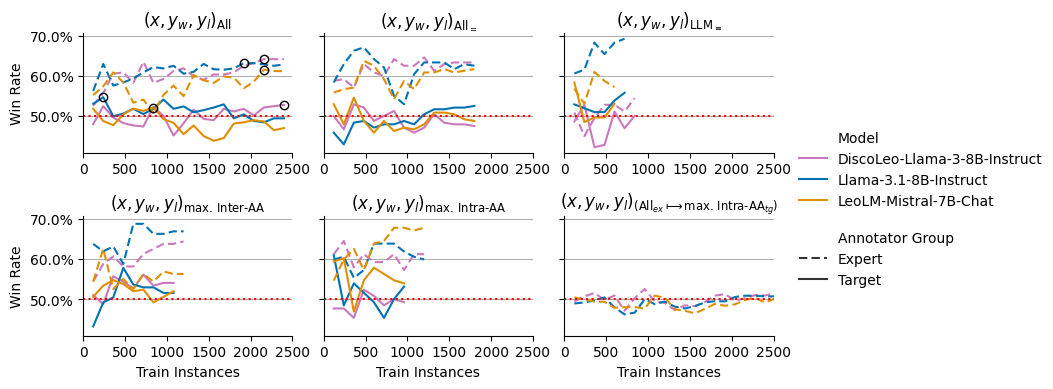

In [158]:
max_points_testwr = dpo_plot_results(test_stats, 'win_rate')

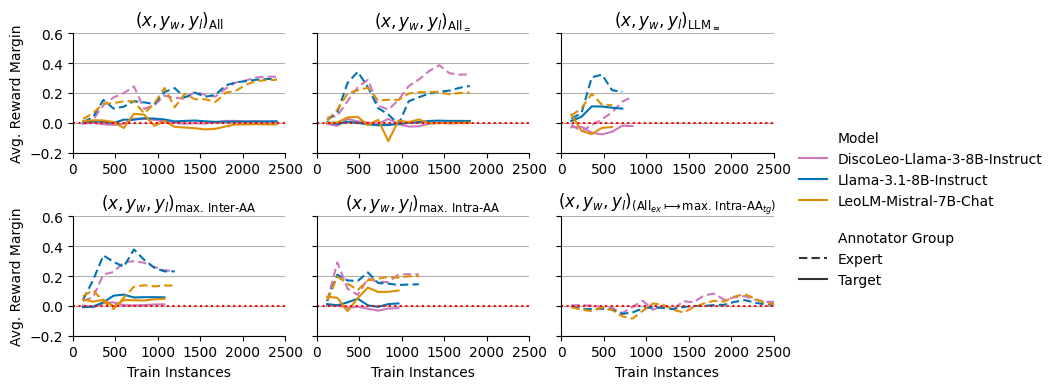

In [159]:
max_points_testmar = dpo_plot_results(test_stats, 'margin')

In [160]:
max_points_devwr

,model,train_steps,win_rate,margin,userGroup,run
8,sft_disco_llama8b_checkpoint2800,135,0.665789,0.325896,ea,all
17,sft_disco_llama8b_checkpoint2800,270,0.555263,0.032284,ta,all
10,sft_llama8b_checkpoint2400,165,0.664474,0.234557,ea,all
11,sft_llama8b_checkpoint2400,180,0.563816,0.039044,ta,all
18,sft_leolm_mistral7b_checkpoint1600,285,0.647368,0.329676,ea,all
12,sft_leolm_mistral7b_checkpoint1600,195,0.561842,0.058048,ta,all
13,sft_disco_llama8b_checkpoint2800,210,0.716667,0.431037,ea,equality
9,sft_disco_llama8b_checkpoint2800,150,0.550000,0.077564,ta,equality
0,sft_llama8b_checkpoint2400,14,0.666667,0.021454,ea,equality
2,sft_llama8b_checkpoint2400,45,0.575000,0.013521,ta,equality


In [168]:
# manual pulls for table

def access_test_performance(test_stats, model, group, variant, max_points_devwr):
    data_variant = 'data'+variant
    tmp = test_stats[test_stats['userGroup'] == group]
    tmp = tmp[tmp['run'] == data_variant]
    if 'disco' in model:
        tmp = tmp[tmp['model'] == 'DPO DiscoLeo Llama']
    elif 'llama' in model:
        tmp = tmp[tmp['model'] == 'DPO Llama']
    elif 'leolm' in model:
        tmp = tmp[tmp['model'] == 'DPO LeoLM Mistral']
    time_step = dpo_dependencies.access_maximal_dev_step_dpo(model, group, variant)*8
    tmp = tmp[np.isclose(tmp['train_steps'], float(time_step))]

    tmp2 = max_points_devwr[max_points_devwr['model'] == model]
    tmp2 = tmp2[tmp2['userGroup'] == group]
    tmp2 = tmp2[tmp2['run'] == variant]
    print(model, group, variant, time_step, round(tmp['win_rate'].values[0], 4), round(tmp2['win_rate'].values[0], 4), round(tmp2['win_rate'].values[0]-tmp['win_rate'].values[0], 3))

for variant in ['all', 'equality', 'model', 'intraAA', 'interAA', 'groupX']:
    print(f'\n {variant} \n')
    for group in ['ta', 'ea']:
        for model in ['sft_disco_llama8b_checkpoint2800', 'sft_llama8b_checkpoint2400', 'sft_leolm_mistral7b_checkpoint1600']:
            if group == 'ta' and variant == 'groupX':
                pass
            else:
                access_test_performance(test_stats, model, group, variant, max_points_devwr)
        print('')
    


 all 

sft_disco_llama8b_checkpoint2800 ta all 2160 0.5211 0.5553 0.034
sft_llama8b_checkpoint2400 ta all 1440 0.5145 0.5638 0.049
sft_leolm_mistral7b_checkpoint1600 ta all 1560 0.4382 0.5618 0.124

sft_disco_llama8b_checkpoint2800 ea all 1080 0.6118 0.6658 0.054
sft_llama8b_checkpoint2400 ea all 1320 0.6099 0.6645 0.055
sft_leolm_mistral7b_checkpoint1600 ea all 2280 0.6118 0.6474 0.036


 equality 

sft_disco_llama8b_checkpoint2800 ta equality 1200 0.4708 0.55 0.079
sft_llama8b_checkpoint2400 ta equality 360 0.4833 0.575 0.092
sft_leolm_mistral7b_checkpoint1600 ta equality 840 0.4625 0.55 0.088

sft_disco_llama8b_checkpoint2800 ea equality 1680 0.6333 0.7167 0.083
sft_llama8b_checkpoint2400 ea equality 120 0.5833 0.6667 0.083
sft_leolm_mistral7b_checkpoint1600 ea equality 1680 0.6125 0.6208 0.008


 model 

sft_disco_llama8b_checkpoint2800 ta model 120 0.4861 0.5528 0.067
sft_llama8b_checkpoint2400 ta model 600 0.5385 0.5865 0.048
sft_leolm_mistral7b_checkpoint1600 ta model 240 0.484

In [76]:
tmp = test_stats[test_stats['userGroup'] == 'ea']
tmp = tmp[tmp['run'].str.contains('int')]
tmp = tmp[tmp['model'] == 'DPO LeoLM Mistral']
tmp

,model,train_steps,win_rate,margin,userGroup,run
0,DPO LeoLM Mistral,120.0,0.592105,0.026673,ea,datainterAA
1,DPO LeoLM Mistral,240.0,0.611842,0.052759,ea,datainterAA
2,DPO LeoLM Mistral,360.0,0.651316,0.231991,ea,datainterAA
3,DPO LeoLM Mistral,480.0,0.677632,0.300717,ea,datainterAA
4,DPO LeoLM Mistral,600.0,0.671053,0.330902,ea,datainterAA
5,DPO LeoLM Mistral,720.0,0.651316,0.152581,ea,datainterAA
6,DPO LeoLM Mistral,840.0,0.559211,0.091080,ea,datainterAA
7,DPO LeoLM Mistral,960.0,0.539474,0.118018,ea,datainterAA
8,DPO LeoLM Mistral,1080.0,0.559211,0.128698,ea,datainterAA
9,DPO LeoLM Mistral,1200.0,0.565789,0.122183,ea,datainterAA
